In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

In [34]:
COST_FOR_SICK = 10000 # per year
COST_FOR_HEALTHY = 500 # per year
SICKNESS_PREVALENCE = 0.05

In [178]:
def average_cost_correctly_classified_healthy(p, fpr, cost_per_healthy):
    return (1 - p) * (1 - fpr) * cost_per_healthy

def average_cost_misclassified_sick(p, tpr, cost_per_sick):
    return p * (1 - tpr) * cost_per_sick

def total_enrolled(p, fpr, tpr):
    total_sick_enrolled = p * (1 - tpr)
    total_healthy_enrolled = (1 - p) * (1 - fpr)
    return total_sick_enrolled + total_healthy_enrolled

def average_premium_to_break_even(fpr, 
                                  tpr, 
                                  cost_for_sick=COST_FOR_SICK, 
                                  cost_for_healthy=COST_FOR_HEALTHY, 
                                  p=SICKNESS_PREVALENCE):
    cost = average_cost_misclassified_sick(p, tpr, cost_for_sick)
    cost += average_cost_correctly_classified_healthy(p, fpr, cost_for_healthy)
    premium = cost / total_enrolled(p, fpr, tpr) / 12
    if isinstance(fpr, numpy.ndarray):
        premium[(tpr < fpr) | (tpr < 0.2)] = NaN
    return premium

def profit_per_patient(fpr, 
                       tpr, 
                       daily_premium,
                       cac=0,
                       cost_for_sick=COST_FOR_SICK, 
                       cost_for_healthy=COST_FOR_HEALTHY, 
                       p=SICKNESS_PREVALENCE):
    # all values normalized to one person
    cost = cac
    cost += average_cost_misclassified_sick(p, tpr, cost_for_sick)
    cost += average_cost_correctly_classified_healthy(p, fpr, cost_for_healthy)
    profit_per_person = total_enrolled(p, fpr, tpr) * daily_premium * 365 - cost
    if isinstance(fpr, np.ndarray):
        profit_per_person[(tpr < fpr)] = np.NaN
    return profit_per_person

def from_4_cats_to_2(cs, ps):
    assert len(cs) == 4
    assert len(ps) == 4
    if cs != sorted(cs):
        print "costs and prevalences must be from healthiest to sickest"
        return 0, 0, 0
    
    cost_for_healthy = cs[0] * ps[0] + cs[1] * ps[1]
    if cost_for_healthy > 0:
        cost_for_healthy /= (ps[0] + ps[1])
    cost_for_sick = cs[2] * ps[2] + cs[3] * ps[3] 
    if cost_for_sick > 0:
        cost_for_sick /= (ps[2] + ps[3])
    p_sick = ps[2] + ps[3]
    return cost_for_healthy, cost_for_sick, p_sick

def profit_per_patient_4_cats(fpr, 
                       tpr, 
                       daily_premium,
                       cac,
                       costs,
                       prevalences):
    cost_for_healthy, cost_for_sick, p_sick = from_4_cats_to_2(costs, prevalences)
    return cost_for_healthy, \
            cost_for_sick, \
            p_sick, \
            profit_per_patient(fpr, tpr, daily_premium, cac, cost_for_sick, cost_for_healthy, p_sick)


In [124]:
def small_mock_unit_tests():
    # fpr == 0 means no healthy patient is denied insurance
    # tpr == 0 means all exploding patients are insured
    assert total_enrolled(p=0.1, fpr=0, tpr=0) == 1.0
    x = profit_per_patient(fpr=0, 
                          tpr=0, 
                          daily_premium=1000.0/365, 
                          cost_for_sick=100, 
                          cost_for_healthy=1, 
                          p=0.1)
    assert x == 1000 - 10 - 0.9, x
    
    # fpr == 0 means no healthy patient is denied insurance
    # tpr == 1 means all exploding patient are denied insurance
    assert total_enrolled(p=0.1, fpr=0, tpr=1) == 0.9
    x = profit_per_patient(fpr=0, 
                          tpr=1, 
                          daily_premium=1000.0/365, 
                          cost_for_sick=100, 
                          cost_for_healthy=1, 
                          p=0.1)
    assert x == 900 - 0.9, x
    
    # fpr == 1 means all healthy patients are denied insurance
    # tpr == 1 means all exploding patients are denied insurance
    assert total_enrolled(p=0.1, fpr=1, tpr=1) == 0
    x = profit_per_patient(fpr=1, tpr=1, daily_premium=1000.0/365)
    assert x == 0, x
    
    assert total_enrolled(p=0.1, fpr=0, tpr=1) == 0.9
    x = profit_per_patient(fpr=0, 
                          tpr=1,
                          cac=5,
                          daily_premium=1000.0/365, 
                          cost_for_sick=100, 
                          cost_for_healthy=1, 
                          p=0.1)
    assert x == 900 - 0.9 - 5, x
    
small_mock_unit_tests()

In [148]:
import matplotlib.colors as colors

cm = plt.get_cmap('RdYlGn')
c_norm = colors.Normalize(vmin=-500, vmax=500)

In [149]:
# f, axs = plt.subplots(2, 2, figsize=(14, 14))
# xvec = np.linspace(0, 1, 1000)                               
# x, y = np.meshgrid(xvec, xvec)
# for premium, ax in zip(range(4), axs.ravel()):
#     z = profit_per_patient(x, y, premium)
#     cs = ax.contourf(x, y, z, 100, cmap=cm, norm=c_norm) 
#     f.colorbar(cs, norm=c_norm, ax=ax, shrink=0.9) 
#
#     ax.set_xlabel('fpr')
#     ax.set_ylabel('tpr')
#     ax.set_title('yearly profit per patient (premium = {}$/day)'.format(premium))
# plt.show()

In [150]:
from ipywidgets import interact

In [212]:
def auc_to_roc(auc, x=np.arange(0, 1, 0.01)):
    # ax^2 + bx + c = 0
    # passing through (0,0) and (1,1)
    # with the integral equaling auc
    return (3 - 6 * auc) * x * x + (6 * auc - 2) * x

In [219]:
def plot_profit_2_cats(daily_premium, cac, cost_for_sick, cost_for_healthy, prevalence, plot_research=False, step=100):
    xvec = np.linspace(0, 1, 50)                               
    x, y = np.meshgrid(xvec, xvec)
    z = profit_per_patient(x, y, daily_premium, cac, cost_for_sick, cost_for_healthy, prevalence)
    v = range(int(np.nanmin(z))/step*step, int(np.nanmax(z))/step*step+step, step)
    cs = plt.contourf(x, y, z, v, cmap=cm, norm=c_norm, origin='lower') 
    cs2 = plt.contour(cs, levels=cs.levels[::2], colors='b', origin='lower')
    cbar = plt.colorbar(cs, norm=c_norm, shrink=0.9) 
    cbar.add_lines(cs2)

    if plot_research:
        plt.plot(xvec, auc_to_roc(0.77, xvec), 'k--', label='stroke auc=0.77')
        plt.legend(loc='lower right')

    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.title('yearly profit per patient\nhealthy cost {:.0f}, sick cost {:.0f}, p_sick {:.2f}'.format(\
                cost_for_healthy, cost_for_sick, prevalence))
    plt.ylim(0, 1)
    plt.show()
    
def plot_profit_4_cats(daily_premium, 
                       cac, 
                       cost0=0, 
                       cost1=1000,
                       p1=0.05, 
                       cost2=5000, 
                       p2=0.03, 
                       cost3=10000, 
                       p3=0.02,
                       **kwargs):
    xvec = np.linspace(0, 1, 50)                               
    x, y = np.meshgrid(xvec, xvec)
    c_h, c_s, p_s, z = profit_per_patient_4_cats(x, 
                                                 y, 
                                                 daily_premium, 
                                                 cac, 
                                                 [cost0, cost1, cost2, cost3], 
                                                 [(1-p1-p2-p3), p1, p2, p3])
    plot_profit_2_cats(daily_premium, cac, c_s, c_h, p_s, **kwargs)

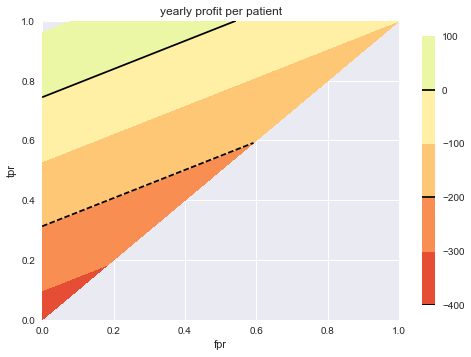

<function __main__.plot_profit>

In [217]:
interact(plot_profit_2_cats, 
         daily_premium=(0, 4, 0.5),
         cac=(0, 200, 10),
         cost_for_sick=(5000, 20000, 5000),
         cost_for_healthy=(0, 1000, 500),
         prevalence=(0.01, 0.1, 0.01))

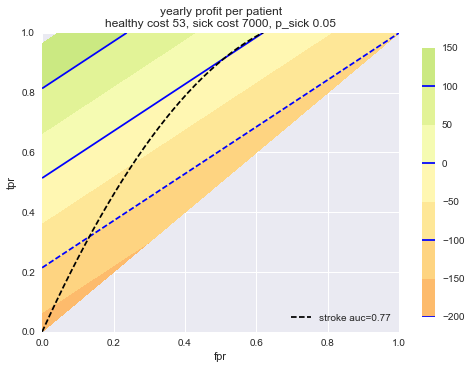

In [221]:
interact(plot_profit_4_cats, 
         daily_premium=(0, 2, 0.1),
         cac=(0, 200, 10),
         cost0=(0, 10000, 100),
         cost1=(0, 10000, 100),
         p1=(0, 0.2, 0.01),
         cost2=(0, 10000, 100),
         p2=(0, 0.2, 0.01),
         cost3=(0, 10000, 100),
         p3=(0, 0.2, 0.01), 
         plot_research=True,
         step=(50, 100, 50))